# Optik Koherens Tomografiden hastalık teşhisi (Sınıflandırma)

<img src=https://raw.githubusercontent.com/brktzlk/OCT_Hastalik_Teshisi/main/Resimler/oct.jpg width="750" align="left">

        21. yüzyılda, optik koherens tomografinin (OCT) gelişimi, maküler hastalıkları teşhis etme ve tedavilerin gerekliliğini ve etkinliğini değerlendirme becerisinde çığır açmıştır. Dünya çapında her yıl gerçekleştirilen yaklaşık 30 milyon OCT taramasıyla en sık uygulanan tıbbi görüntüleme prosedürlerinden biri haline geldi. OCT görüntüleme artık dünya çapında önlenebilir körlüğün önde gelen nedenlerinden yaşa bağlı makula dejenerasyonu (AMD) ve diyabetik maküla ödeminin tanı ve tedavisine rehberlik eden bir standart haline gelmiştir.

-------------------------------------------------------------------------------------------------------------------------------------

## Standart kütüphaneleri içe aktarma

In [16]:
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install opencv-python
#%pip install tensorflow
#%pip install efficientnet

In [17]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

seed = 2019
np.random.seed(seed)
%matplotlib inline

## Dosyanın bulunduğu konum

In [18]:
path  = 'OCT2017_az'
train = path + '/train'
test  = path + '/test'
path,train,test

('OCT2017_az', 'OCT2017_az/train', 'OCT2017_az/test')

## Veri büyütme  (Data augmentation) 

[ImageDataGenerator()](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) 

In [19]:
from keras.preprocessing.image import ImageDataGenerator
#görsellerin tersini alarak sağ veya sol kısımda kalan alanları da anlamasını sağladık

train_datagen = ImageDataGenerator(zoom_range = 0.3,
                                   horizontal_flip = True
                                   )
test_datagen = ImageDataGenerator()


## Görüntüleri aktarma

[flow_from_directory()](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) 

In [20]:
#görselleri istediğimiz formata dönüştürdük
train_gen = train_datagen.flow_from_directory(
                            directory = train, 
                            target_size = (160, 160), 
                            batch_size = 16, 
                            class_mode = 'categorical', 
                            shuffle=True)

test_gen = train_datagen.flow_from_directory(
                            directory = test, 
                            target_size = (160, 160), 
                            batch_size = 16, 
                            class_mode = 'categorical', 
                            shuffle=True)

Found 4168 images belonging to 4 classes.
Found 1010 images belonging to 4 classes.


### Callbacks 
- Callback nedir?
Egitimin belirli asamalarinda uygulanacak bir dizi islevdir.
Egitim sirasinda modelin durumu ve istatistikleri hakkinda bilgi elde etmek için de kullanilabilir.
- ReduceLROnPlateau()
Model gelismeyi durdurdugunda ögrenme oranini azaltir.
- ModelCheckpoint ()
Modeli veya model agirliklarini belirli bir siklikta kaydeder.


In [21]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=2, mode='max')#val_loss skoru durağanlaştığında öğrenme oranı düşürme
cp = ModelCheckpoint(filepath='eff_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)#her epochdaki ağırlığı dosya yoluna kaydeder

## Model Oluşturma - Transfer Learning ( EfficientNet B5 )

    Araştırma yapılırken(2018) transfer learning modeli olarak InceptionV3 kullanılmış ve %96.6 accuracy skoru elde edilmiş. Fakat günümüzde(2023) InceptionV3'den daha başarılı modeller mevcut. Bu nedenle kursta EfficientNet modelini kullanıyoruz.Sürüm  farkından hata almamak için bu modeli kullandık.

In [22]:
from efficientnet.keras import EfficientNetB5
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


model = Sequential()
model.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(160,160,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4,activation = 'softmax')) #4 sınıflı multiclass sınıflandırma
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [23]:
history_eff = model.fit(
           train_gen, steps_per_epoch=train_gen.samples/16, #aşırı yükleme olmasın diye 16 kullandık
           epochs=10,        
           validation_data=test_gen, 
           validation_steps=test_gen.samples // 16,
           callbacks=[lr, cp],
           verbose=1)

Epoch 1/10
260/260 [==============================] - 370s 1s/step - loss: 0.5917 - accuracy: 0.7975 - val_loss: 1.0478 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 2/10
260/260 [==============================] - 355s 1s/step - loss: 0.3081 - accuracy: 0.9045 - val_loss: 0.1168 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 3/10
260/260 [==============================] - 365s 1s/step - loss: 0.2573 - accuracy: 0.9232 - val_loss: 0.1505 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/10
260/260 [==============================] - 364s 1s/step - loss: 0.1752 - accuracy: 0.9453 - val_loss: 0.2097 - val_accuracy: 0.9454 - lr: 0.0010
Epoch 5/10
260/260 [==============================] - 362s 1s/step - loss: 0.1622 - accuracy: 0.9503 - val_loss: 0.0853 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 6/10
261/260 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9587
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
260/260 [==============================] - 358s 

## CNN 

In [30]:
#yukarda elde ettiğimiz sonuçlar %97 civarında sonuç aldık ancak farklı bir model deneyip daha iyi sonuç alabilir miyiz onu denedik.
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization

model_2 = Sequential([
# 3,3 yerine çift sayı kullansaydık performansı düşürürdü ve büyük filtre kullanmakda günler süren iş demektir
Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),#16 filtresini kullandık ayrıntılı sonuç versin diye
MaxPool2D((2, 2)),
    
Conv2D(32, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),

Conv2D(64, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),

Conv2D(128, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),
    
Conv2D(256, (3, 3), activation='relu'),
BatchNormalization(),
MaxPool2D(pool_size=(2, 2)),
Dropout(rate=0.2),#aşırı yükleme olmasın diye dropout kullandık

Flatten(),
Dense(units=1024, activation='relu'),
Dropout(rate=0.3),

Dense(units=4, activation='softmax') ])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [31]:
cp = ModelCheckpoint(filepath='basit_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)

history_cnn = model_2.fit(
           train_gen, 
           steps_per_epoch=train_gen.samples/32, 
           epochs=10,        
           validation_data=test_gen, 
           validation_steps=test_gen.samples // 32,
           callbacks = [cp])

Epoch 1/10
130/130 [==============================] - 13s 93ms/step - loss: 2.2349 - accuracy: 0.4785 - val_loss: 1.2204 - val_accuracy: 0.4980
Epoch 2/10
130/130 [==============================] - 11s 86ms/step - loss: 0.9746 - accuracy: 0.6302 - val_loss: 0.9395 - val_accuracy: 0.6169
Epoch 3/10
130/130 [==============================] - 11s 86ms/step - loss: 0.7629 - accuracy: 0.7104 - val_loss: 2.6463 - val_accuracy: 0.2802
Epoch 4/10
130/130 [==============================] - 11s 87ms/step - loss: 0.7130 - accuracy: 0.7246 - val_loss: 1.7821 - val_accuracy: 0.4234
Epoch 5/10
130/130 [==============================] - 11s 87ms/step - loss: 0.6148 - accuracy: 0.7768 - val_loss: 2.0389 - val_accuracy: 0.3952
Epoch 6/10
130/130 [==============================] - 11s 87ms/step - loss: 0.6521 - accuracy: 0.7625 - val_loss: 0.6440 - val_accuracy: 0.7540
Epoch 7/10
130/130 [==============================] - 11s 87ms/step - loss: 0.5868 - accuracy: 0.7816 - val_loss: 0.6176 - val_accuracy:

# Accuracy-Loss grafiği

#### Accuracy

In [32]:
history = history_eff

Text(0.5, 0, 'epoch')

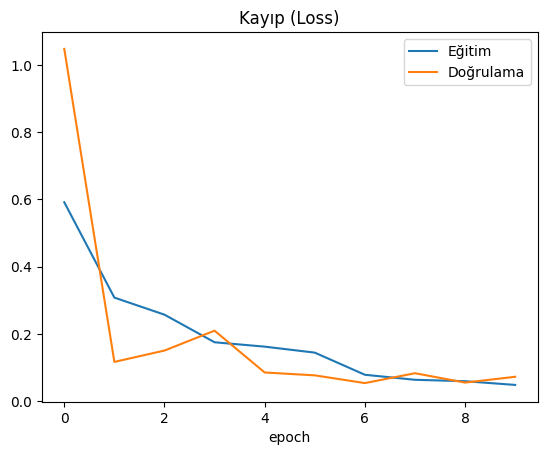

In [33]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp (Loss)')
plt.xlabel('epoch')

#### Loss

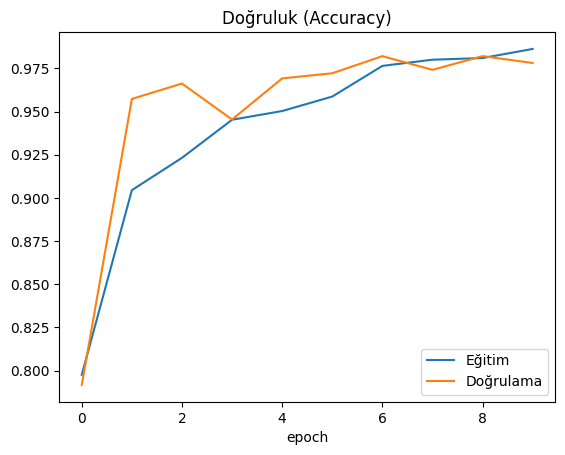

In [34]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk (Accuracy)')
plt.xlabel('epoch')
plt.show()

# Hata Matrisi (Confusion Matrix)

#### Verileri aktarma 

In [36]:
dosya = os.listdir(path+'/train')

In [54]:
#verileri matrise aktarırken array formatında olması gerekiyor
test_data = []
test_labels = []

for name in dosya:
    for img in os.listdir(test +'/'+ name ):
        img = plt.imread(test +'/'+ name + '/' + img)
        img = cv2.resize(img, (160, 160)) #görüntüleri okuduktan sonra tekrar eski haline getirdik
        img = np.dstack([img, img, img])
        img = img.astype('float32')
        
        if   name =='CNV':
            label = 0
        elif name =='DME':
            label = 1
        elif name =='DRUSEN':
            label = 2
        elif name =='NORMAL':
            label = 3
            
        test_data.append(img)
        test_labels.append(label)
        
x_test = np.array(test_data) #arraya çevirdik
y_test = np.array(test_labels) #göz uzmanlarınınsınıflandırması
y_pred = model.predict(x_test) #yapay zekanın sınıflandırması
y_pred_clas = np.argmax(y_pred, axis=-1)


32/32 [==============================] - 17s 518ms/step


In [55]:
%pip install scikit-learn
%pip install seaborn
%pip install scikit-plot


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<Axes: >

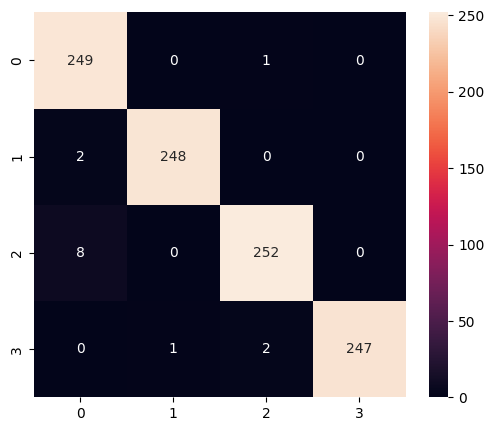

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_clas)
plt.figure(figsize = (6,5)) #kare grafik elde ettik
sns.heatmap(cm,fmt='.4g', annot=True) #fmt ile formati belirledik
#yukarısı bilgisayar tahmini,yan taraf uzman bilgisi

# ROC Eğiris ()

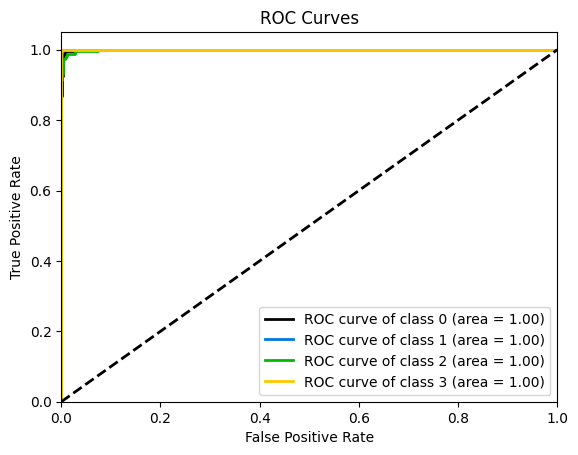

In [57]:
import scikitplot as skplt #4 sınıfımız olduğu için bu kütüphaneyi kullandık otomatik ayırır sınıflara
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_test,
                       y_pred,
                       plot_micro=False,
                       plot_macro=False)
plt.show()